In [144]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
from scipy.special import lambertw

from fluid_ppt import *
from setup_ax import *

Psat = 1.01e5 #Pa
ppt = fluid_ppt_sat('water', Psat)

Tsat = ppt['Tsat']
DTw = 5
DTl = 3

Tw = Tsat + DTw
Tl = Tsat - DTl

Jaw = ppt['rho_l'] * ppt['cp_l'] * DTw / (ppt['rho_v'] * ppt['h_lv'])
Jal = ppt['rho_l'] * ppt['cp_l'] * DTl / (ppt['rho_v'] * ppt['h_lv'])
alpha_l = ppt['alpha_l']

theta = 0 * np.pi / 180

fV = 0.25 * (2 - np.cos(theta)) * ((1 + np.cos(theta))**2)

delta = 1e-3

def expgrowth(t):
    Ka = (1 + np.cos(theta))**2 * Jaw * np.sqrt(alpha_l) * (1 + Jal / Jaw) / (4 * delta * fV) 
    Kb = Jaw * np.sqrt(alpha_l) * (1 + np.cos(theta)) / (2 * fV)
    Rinf = Kb / Ka
    res = Rinf * (1 - np.exp(-2 * Ka * np.sqrt(t)))
    
    return (Rinf, res)

def delta_val():
    Ka = (1 + np.cos(theta))**2 * Jaw * np.sqrt(alpha_l) * (1 + Jal / Jaw) / (4 * delta * fV) 
    Kb = Jaw * np.sqrt(alpha_l) * (1 + np.cos(theta)) / (2 * fV)
    Rinf = Kb / Ka
    Rdelta = delta / (1 + np.cos(theta))
    tdelta = ( (-1/(2*Ka))* np.log( 1 - delta / (Rinf * (1+np.cos(theta))) ) )**2
    
    return (tdelta, Rdelta)

def Wgrowth(t, tdelta, Rdelta):
    Ka = Jaw * np.sqrt(alpha_l) * delta * (1 + Jal / Jaw) / (4 * fV)
    Kb = - Jal * np.sqrt(alpha_l) * (1 + np.cos(theta)) / (2 * fV)
    C = (Kb * Rdelta - Ka * np.log(abs(Kb * Rdelta + Ka))) / (2 * Kb**2) - np.sqrt(tdelta)
    
    E = 2 * (Kb**2) * np.sqrt(t) + Ka + 2 * Kb**2 * C
    res = - Ka / Kb * (1 + lambertw((-1/Ka) * np.exp(-E/Ka)) )
    Rinf = - Ka / Kb

    return (Rinf,res)    


def Tl(y, dTBL, Tsup, Tsub):
    if 0 < y < dTBL:
        res = Tsup + (Tsub - Tsup) * y / dTBL
    elif y > dTBL :
        res = Tsub
    else:
        print('Error: y<0 has no temperature')
        return

    return res

0.006687182925243937 0.0005 0.001


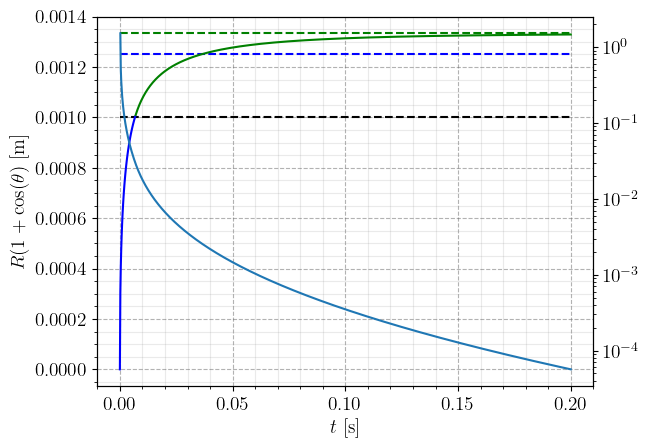

In [147]:
fig, ax = plt.subplots()

setup_ax(ax, xlabel=r'$t$ [s]', ylabel=r'$R(1+\mathrm{cos}(\theta)$ [m]')

tList = np.linspace(0,0.2,1000)

ax.plot(tList, [delta for t in tList], '--k')

t1 = []
t2 = []
R1 = []
R2 = []

R = 0
(Rinf1, R) = expgrowth(0)
if Rinf1 > 0:
    ax.plot(tList,[Rinf1*(1+np.cos(theta)) for t in tList], '--b')

if Jal / Jaw < 1:
    (td, Rd) = delta_val() 
    print(td, Rd, Rd*(1+np.cos(theta)))
    (Rinf2, R) = Wgrowth(0, td, Rd)
    if Rinf2 > 0:
       ax.plot(tList,[Rinf2*(1+np.cos(theta)) for t in tList], '--g')

R = 0
for t in tList:
    if R*(1 + np.cos(theta)) < delta:
        (Rinf1, R) = expgrowth(t)
        t1.append(t)
        R1.append(R*(1+np.cos(theta)))
    else :   
        (Rinf2, R) = Wgrowth(t, td, Rd)
        t2.append(t)
        R2.append(R*(1+np.cos(theta)))


ax.plot(t1,R1, '-b')
ax.plot(t2,R2, '-g')

dt=t1[1]-t1[0]
R=np.array(R1+R2)
t=np.array(t1+t2)
derivee=(R[1:]-R[:-1])/dt
ax2=ax.twinx()
ax2.set_yscale('log')
ax2.plot(t[1:],derivee)
plt.savefig('test.pdf', format='pdf')

q83.7_f1688.81.txt 83700.0 1688.81


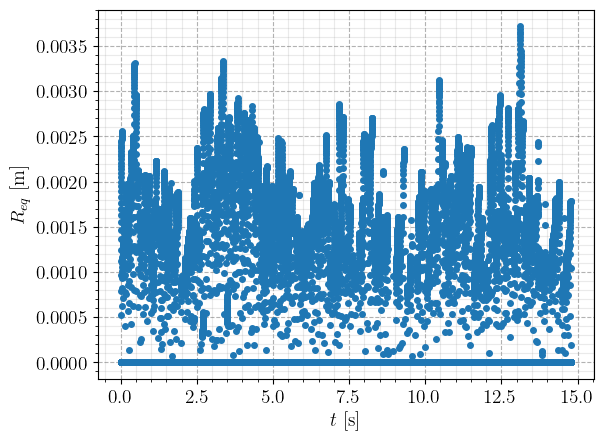

In [145]:
import os
import numpy as np
import json

# Y.J exp data conversion to .json file

def sort_bubbles(tList, rList): # tList and rList must be np arrays
    res = {}
    mask = rList > 0
    idx = np.where(mask)[0]
    splits = np.where(np.diff(idx) > 1)[0] + 1
    segments = np.split(idx, splits)
    t_split = [tList[i] for i in segments]
    r_split = [rList[i] for i in segments]
    
    nb = 0
    res = {}
    for i in range(len(t_split)):
        t = t_split[i]
        r = r_split[i]
        bub = {'t_s' : list(t), 'Req_m' : list(r)}
        nb += 1
        if len(t) > 10:
            res[f'Bubble_{nb}'] = bub
    
    return res      


fig, ax1 = plt.subplots()
setup_ax(ax1, xlabel=r'$t$ [s]', ylabel=r'$R_{eq}$ [m]')

fexp = [f for f in os.listdir('.') if f.endswith('.txt')]
res = {}
for fName in fexp:
    f = fName[:-4].split('_')
    qw = float(f[0][1:])*1e3 #W/m2
    fps = float(f[1][1:]) #1/s
    
    print(fName, qw, fps)
    res['qj_W/m2']= qw
    res['fps'] = fps
    
    f = open(fName, 'r')
    data = f.read()
    f.close()

    nfr = 200
    data = [float(v) for v in data.split('\n')[:-1]]
    frame = [i for i in range(len(data))]
    
    req = [((3/(4*np.pi))*v)**(1/3) for v in data]
    req = np.array(req)
    time = [f/fps for f in frame]
    time = np.array(time)
    
    
    ax1.scatter(time, req)
    
    bDic = sort_bubbles(time, req)
    res['Bubbles'] = bDic
    
    with open(f'q{round(qw/1000,1)}_f{int(fps)}.json', 'w') as json_file:
        json.dump(res, json_file, indent = 4)

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
from scipy.special import lambertw

from fluid_ppt import *
from setup_ax import *

def modGr(tList, P_Pa, DTw, DTl, theta, delta, fluid):

    ppt = fluid_ppt_sat(fluid, P_Pa)

    Tsat = ppt['Tsat']
    Tw = Tsat + DTw
    Tl = Tsat - DTl

    Jaw = ppt['rho_l'] * ppt['cp_l'] * DTw / (ppt['rho_v'] * ppt['h_lv'])
    Jal = ppt['rho_l'] * ppt['cp_l'] * DTl / (ppt['rho_v'] * ppt['h_lv'])
    alpha_l = ppt['alpha_l']


    fV = 0.25 * (2 - np.cos(theta)) * ((1 + np.cos(theta))**2)

    # exp growth
    Ka = (1 + np.cos(theta))**2 * Jaw * np.sqrt(alpha_l) * (1 + Jal / Jaw) / (4 * delta * fV) 
    Kb = Jaw * np.sqrt(alpha_l) * (1 + np.cos(theta)) / (2 * fV)
    Rinf = Kb / Ka
    
    Rdelta = delta / (1 + np.cos(theta))
    tdelta = ( (-1/(2*Ka))* np.log( 1 - delta / (Rinf * (1+np.cos(theta))) ) )**2
    
    # W growth
    Kab = Jaw * np.sqrt(alpha_l) * delta * (1 + Jal / Jaw) / (4 * fV)
    Kbb = - Jal * np.sqrt(alpha_l) * (1 + np.cos(theta)) / (2 * fV)
    C = (Kbb * Rdelta - Kab * np.log(abs(Kbb * Rdelta + Kab))) / (2 * Kbb**2) - np.sqrt(tdelta)
    Rinfb = - Kab / Kbb
    
    res = []

    if max(tList) > tdelta:
        Rinf_res = Rinfb
    else:
        Rinf_res = Rinf
        
    r=0
    for i in range(len(tList)):
        t=tList[i]
        if r < Rdelta:
            r = Rinf * (1 - np.exp(-2 * Ka * np.sqrt(t)))
            res.append(r)
        else:
            E = 2 * (Kbb**2) * np.sqrt(t) + Kab + 2 * Kbb**2 * C
            r = - Kab / Kbb * (1 + lambertw((-1/Kab) * np.exp(-E/Kab)) )
            res.append(r)
    return (res, Rinf_res, Rdelta)

0.7502500000000001 0.0005
90.13914020676913


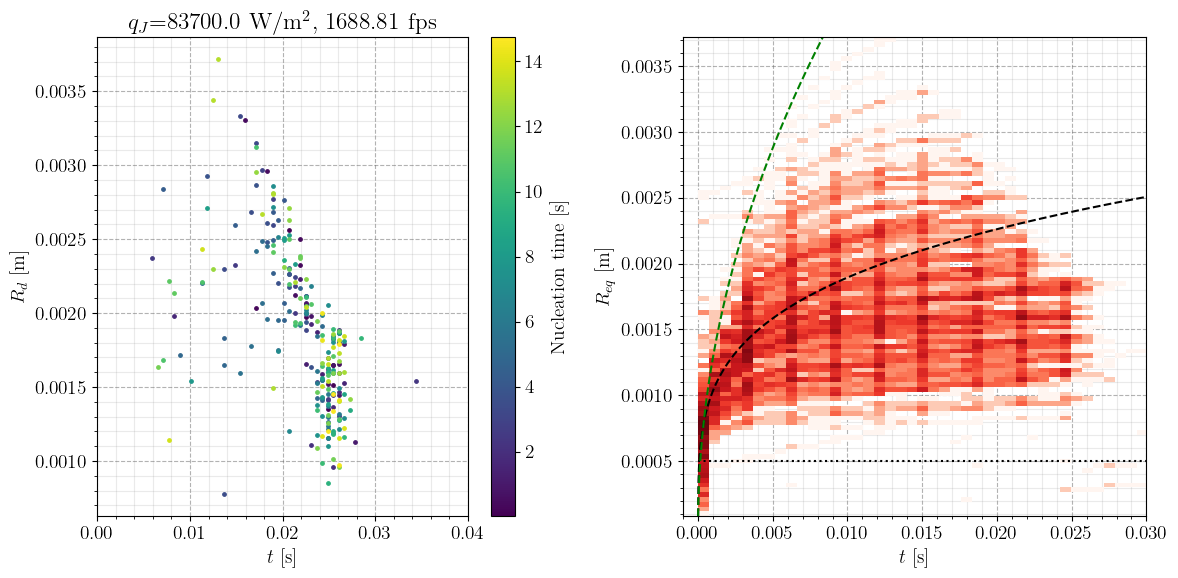

In [180]:
import os
from setup_ax import *
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm

jsonFiles = [f for f in os.listdir('.') if f.endswith('.json')]

f = jsonFiles[0]

with open(f, 'r') as jFile:
    exp_dic=json.load(jFile)

fig, axs = plt.subplots(1,2, figsize=(12,6))
ax1 = axs[0]
setup_ax(ax1, xlabel=r'$t$ [s]', ylabel=r'$R_{d}$ [m]')
ax1.set_title(rf'$q_{{J}}$={{{exp_dic['qj_W/m2']}}} W/m$^2$, {{{exp_dic['fps']}}} fps')

bubDic = exp_dic['Bubbles']

# --- prepare colormap based on t[0] of each segment ---
times = [bubDic[b]['t_s'] for b in bubDic]
t0_values = np.array([t[0] for t in times])
norm = plt.Normalize(vmin=t0_values.min(), vmax=t0_values.max())
cmap = cm.viridis  # or any other colormap: 'plasma', 'turbo', etc.

t_all = []
Req_all = []
Rdep = []
for nb in bubDic:
    b = bubDic[nb]
    t = b['t_s']
    t0 = t[0]
    t = [tv-t0 for tv in t]
    tend = t[-1]
    #t = [tv/tend for tv in t]
    t_all = t_all + t
    Req = b['Req_m']
    Rend = max(Req)
    Rdep.append(Rend)
    #Req = [r/Rend for r in Req]
    Req_all = Req_all + Req
    color = cmap(norm(t0))
    ax1.scatter(tend, Rend, color=color, s=6)

# Add a colorbar to show what colors mean
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1, label="Nucleation time [s]")
ax1.set_xlim(0,0.04)

ax2=axs[1]
setup_ax(ax2, xlabel=r'$t$ [s]', ylabel='$R_{eq}$ [m]')
counts, xedges, yedges, img = ax2.hist2d(
    t_all, Req_all, bins=100, cmap='Reds', density=True, norm = LogNorm()#
)
#ax2.set_ylim(-0.1, 1.1)
ax2.set_xlim(-1e-3, 0.03)

tList = np.linspace(0,0.03,1000)

P = 1.01e5
fluid = 'water'
DTw = 30
DTl = 0.01
theta = 0 * np. pi / 180
delta = 1e-3
(rMod, Rinf, Rdelta) = modGr(tList, P, DTw, DTl, theta, delta, fluid)
print(Rinf, Rdelta)
#rMod = [r/Rinf for r in rMod]
ax2.plot(tList, rMod, '--k')
ax2.plot(tList, [Rdelta for t in tList], ':k')

ppt = fluid_ppt_sat('water', P)
Jaw = ppt['rho_l']*ppt['cp_l']*DTw/(ppt['rho_v']*ppt['h_lv'])
print(Jaw)
Rsq = [2*np.sqrt(3)/np.pi * Jaw*np.sqrt(ppt['alpha_l']*t) for t in tList]
ax2.plot(tList, Rsq, '--g')

plt.tight_layout()

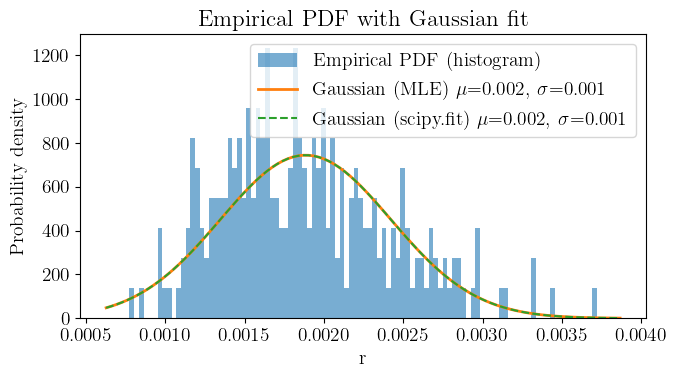

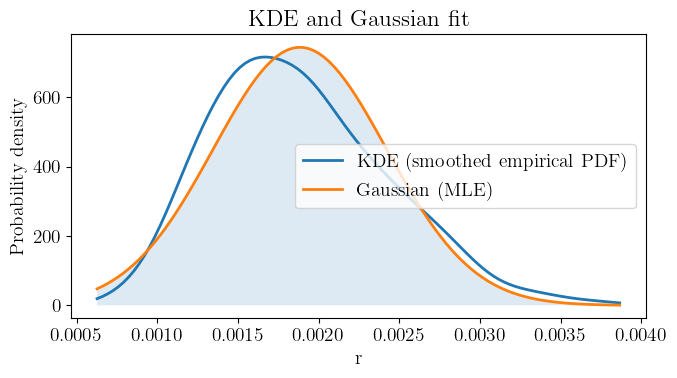

In [192]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


r = np.array(Rdep)
# --- 1) Basic Gaussian fit using sample mean/std (MLE) ---
mu_mle = np.mean(r)
sigma_mle = np.std(r, ddof=0)   # ddof=0 gives population MLE (consistent with scipy's fit default)

# Or use scipy's fitter (it returns the same by default for loc/scale)
mu_scipy, sigma_scipy = stats.norm.fit(r)

# --- grid to evaluate the Gaussian pdf ---
x = np.linspace(r.min() - 0.05*(r.max()-r.min()), r.max() + 0.05*(r.max()-r.min()), 100)

# --- 2A) Plot: normalized histogram + Gaussian overlay ---
plt.figure(figsize=(7,4))
# histogram normalized to a PDF
counts, bins, patches = plt.hist(r, bins=100, density=True, alpha=0.6, label='Empirical PDF (histogram)')

# Gaussian PDFs
plt.plot(x, stats.norm.pdf(x, mu_mle, sigma_mle), lw=2, label=rf'Gaussian (MLE) $\mu$={mu_mle:.3f}, $\sigma$={sigma_mle:.3f}')
plt.plot(x, stats.norm.pdf(x, mu_scipy, sigma_scipy), ls='--', lw=1.5,
         label=rf'Gaussian (scipy.fit) $\mu$={mu_scipy:.3f}, $\sigma$={sigma_scipy:.3f}')

plt.xlabel('r')
plt.ylabel('Probability density')
plt.title('Empirical PDF with Gaussian fit')
plt.legend()
plt.tight_layout()
plt.show()

# --- 2B) Optional: smooth PDF via KDE + Gaussian overlay ---
kde = stats.gaussian_kde(r)
z = kde(x)

plt.figure(figsize=(7,4))
plt.plot(x, z, label='KDE (smoothed empirical PDF)', lw=2)
plt.plot(x, stats.norm.pdf(x, mu_mle, sigma_mle), lw=2, label='Gaussian (MLE)')
plt.fill_between(x, 0, stats.norm.pdf(x, mu_mle, sigma_mle), alpha=0.15)
plt.xlabel('r')
plt.ylabel('Probability density')
plt.title('KDE and Gaussian fit')
plt.legend()
plt.tight_layout()
plt.show()
